In [113]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import matplotlib.dates as mdates


In [115]:
# Load mô hình đã huấn luyện
model = load_model('BSI.keras')

ma_cophieu = "BSI.VN"
start_date = "2025-03-24"
end_date = "2025-03-26"  # Lấy thêm 1 ngày để đảm bảo có đủ dữ liệu
buoc_thoi_gian = "5m"

# Tải dữ liệu từ Yahoo Finance
data = yf.download(ma_cophieu, start=start_date, end=end_date, interval=buoc_thoi_gian)

# Chuyển đổi múi giờ từ UTC sang Asia/Ho_Chi_Minh (GMT+7)
data.index = data.index.tz_convert("Asia/Ho_Chi_Minh")

# Lựa chọn cột giá đóng cửa và loại bỏ NaN
data = data[['Close']].dropna()

[*********************100%***********************]  1 of 1 completed


In [117]:
# Chia dữ liệu theo ngày
data_24 = data.loc["2025-03-24"]
data_25 = data.loc["2025-03-25"]

In [119]:
# Lấy giá tham chiếu ngày 25/03
ref_price = float(data_25.iloc[0]['Close'])
upper_limit = ref_price * 1.07
lower_limit = ref_price * 0.93

/tmp/ipykernel_31175/4216353685.py:2: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ref_price = float(data_25.iloc[0]['Close'])


In [121]:
def apply_tick_size(price):
    if price < 10000:
        return round(price / 10) * 10
    elif price < 50000:
        return round(price / 50) * 50
    else:
        return round(price / 100) * 100

In [123]:
# Chuẩn hóa từng phần
scaler_24 = MinMaxScaler(feature_range=(0, 1))
data_scaled_24 = scaler_24.fit_transform(data_24)

In [125]:
# Dự đoán từng điểm trong ngày 25/3
y_pred = []
X_input = data_scaled_24[-30:].reshape(1, 30, 1)
for i in range(len(data_25)):
    pred = model.predict(X_input)[0, 0]  # Dự đoán điểm tiếp theo
    pred_inv = float(scaler_24.inverse_transform([[pred]])[0, 0])
    
    # Giới hạn trong biên độ 7%
    pred_inv = max(lower_limit, min(upper_limit, pred_inv))
    
    # Áp dụng bước giá
    pred_inv = apply_tick_size(pred_inv)
    
    y_pred.append(pred_inv)
    
    # Cập nhật đầu vào với điểm mới nhất
    X_input = np.append(X_input[:, 1:, :], [[[scaler_24.transform([[pred_inv]])[0, 0]]]], axis=1)
    
    # Nếu có dữ liệu thực tế, cập nhật đầu vào bằng dữ liệu thực tế thay vì dự đoán
    if i < len(data_25) - 1:
        actual_next = scaler_24.transform(data_25.iloc[i + 1].values.reshape(-1, 1))[0, 0]
        X_input[:, -1, 0] = actual_next

# Chuyển dữ liệu về giá trị gốc
y_pred_inv = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

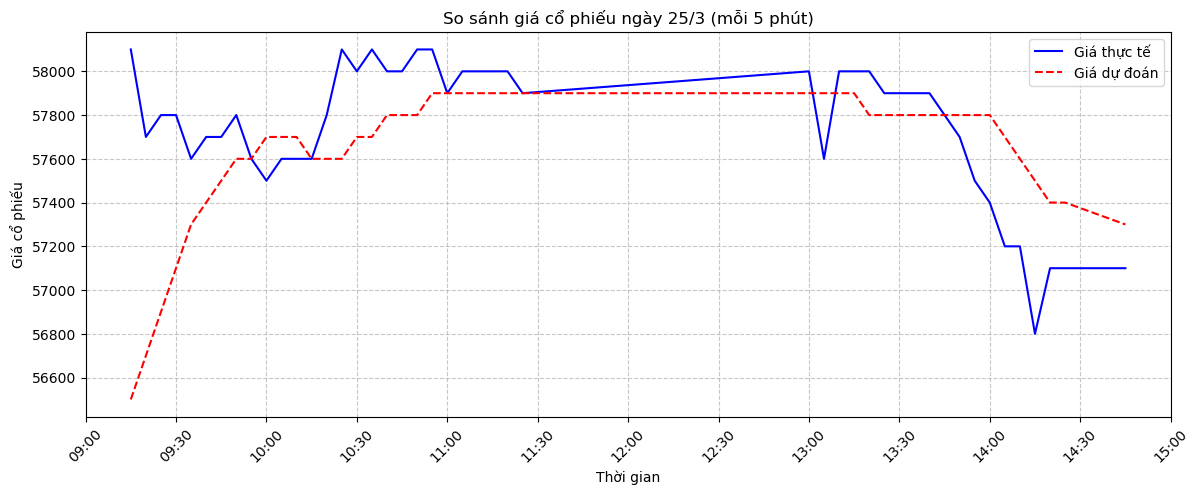

In [131]:
# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(data_25.index, data_25['Close'], color='blue', label='Giá thực tế')
plt.plot(data_25.index, y_pred_inv, color='red', linestyle='dashed', label='Giá dự đoán')
plt.title('So sánh giá cổ phiếu ngày 25/3 (mỗi 5 phút)')
plt.xlabel('Thời gian')
plt.ylabel('Giá cổ phiếu')
plt.legend()

# Hiển thị trục x theo hh:mm
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", tz=data.index.tz))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # Mỗi 30 phút một mốc
plt.xticks(rotation=45)

# Giới hạn trục x trong ngày 25/03
start_time = pd.Timestamp("2025-03-25 09:00", tz="Asia/Ho_Chi_Minh")
end_time = pd.Timestamp("2025-03-25 15:00", tz="Asia/Ho_Chi_Minh")
plt.xlim(start_time, end_time)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()